In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import sklearn

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

HOME = Path(".")

# PyTorch data handling

There are two main data-handling objects in PyTorch.
- `torch.utils.data.Dataset`: is an ordered collection of data samples and their labels (if available). PyTorch provides several implementations of these objects for commonly used datasets [here](https://pytorch.org/vision/stable/datasets.html). These usually download the data and have code to access each sample preprocessed with a `torch.transforms` if provided by the user.
- `torch.utils.data.DataLoader`: this class will wrap a `Dataset` with an iterator and serve it sequentially, in mini-batches if requested. When preparing the mini-batches the `DataLoader` must collate several examples into a single tensor. This is done by the `collate_fn` argument that can be passed to the `DataLoader` constructor. In most cases the default implementation of this function is sufficient.  

Here is an example of using these classes to obtain the publicly available FashionMNIST and iterating over it.

In [45]:
training_data = torchvision.datasets.FashionMNIST(
    root="data/fashionmnist",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

for epoch in range(2):
    for data, labels in train_dataloader:
        # Here we could do a gradient descent step on our model parameters
        pass

## MNIST data

The MNIST database of handwritten digits scanned into gray-scale images. The digits have been size-normalized and centered in a fixed-size image.

We can easily download the data and load it as PyTorch tensors using [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/datasets.html#mnist)

The output of torchvision datasets are PILImage images of range $[0, 1]$. We transform them to PyTorch tensors and normalize them to have zero mean and a range of $[-1, 1]$ by creating a transform object and pass it to the dataset constructor:

```
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
```


## Exercise 1
Download and load the train and test splits of the MNIST dataset into variables `train_set` and `test_set`.

In [46]:
transform_mnist = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5, )) # only one channel for grayscale image
    ]
)

training_data_mnist = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform=transform_mnist
)

test_data_mnist = torchvision.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=transform_mnist
)

train_dataloader = torch.utils.data.DataLoader(
    training_data_mnist, batch_size=64, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    test_data_mnist, batch_size=64, shuffle=True)


Next we are going to explore and visualize the data.

## Exercise 2
Print how many examples there are in total and the size of the images. 

Plot the first example and set the title to its label.

You can access examples in a dataset by indexing it with an integer: ```first_example = my_dataset[0]```

You may use `plt.imshow` to show the examples, use a grayscale colormap when doing so.

Numer of images: 60000, size in total: torch.Size([1, 28, 28])


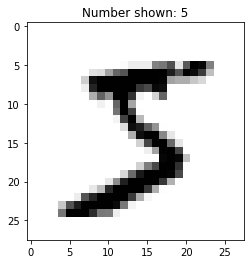

In [47]:

first_example, title_first = training_data_mnist[0] # Getting first image

print(f"Numer of images: {len(training_data_mnist)}, size in total: {first_example.shape}")

first_example_image = torch.squeeze(first_example) # Image must be (N x N)
plt.title(f"Number shown: {title_first}")
plt.imshow(first_example_image, cmap=plt.cm.binary)


We can perform multiple plots using [`Figure.add_subplot`](https://matplotlib.org/stable/api/figure_api.html?highlight=fig%20add_subplot#matplotlib.figure.Figure.add_subplot) like in the following snippet:
```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

This function returns an `Axis` object. We may then call the methods `Axis.imshow()`, `Axis.set_xticks()` and `Axis.set_xlabel`.

After all the plotting we may call `plt.tight_layout()` to adjust the layout of the plots.

Finally may use Python's function [`enumerate`](https://docs.python.org/3.6/library/functions.html#enumerate) to keep track of the index of axis object we are operating on.

## Exercise 3
Using `matplotlib` plot a set of 25 images (in a 5x5 grid) and set as their x-label the label assigned to each.

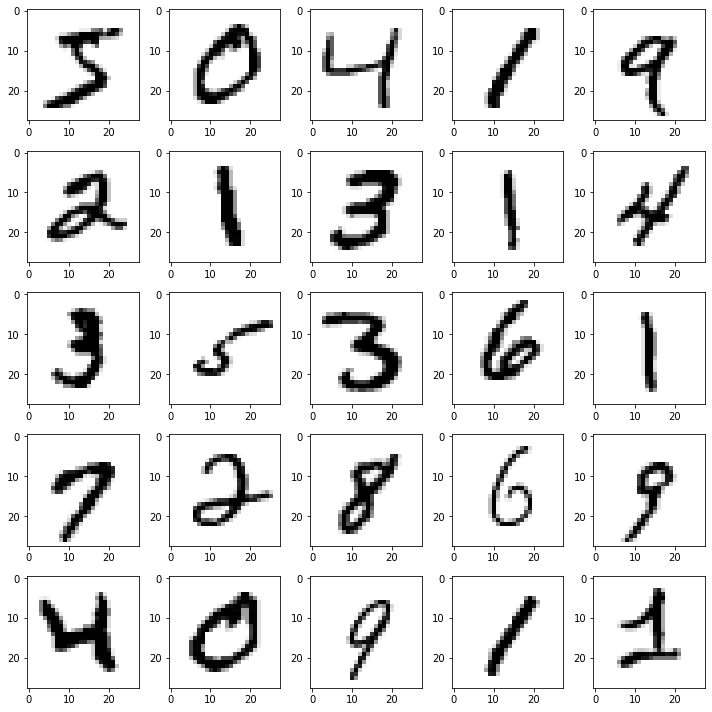

In [48]:

n_rows = 5
n_cols = 5
fig = plt.figure(figsize=(10, 10)) # width and height in inches? lol

for i, image in enumerate(training_data_mnist):
    if i >= n_rows*n_cols:
        break

    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # Getting image and prepare it for visualisation
    image_tensor, label = image 
    image_tensor = torch.squeeze(image_tensor)

    plt.imshow(image_tensor, cmap=plt.cm.binary)


plt.tight_layout()


## PyTorch model

PyTorch uses an object oriented approach to defining models. We must inherit from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module) and override the constructor and the `forward` method. For instance te recreate the model we used in our previous lab we will do the following:

```
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
```

**Remark**: Note that we have not applied the `torch.sigmoid` activation function on the last layer. Many criterion functions (loss functions) used in PyTorch operate on what we call the *logits*. Logits are the pre-activations of the last layer. In other words, in PyTorch we often don't have an output activation function inside the model and rather let the criterion apply it internally when computing the error.

In our current problem, we must classify each image as one out of 10 different classes. Therefore for the output we will need 10 units. When interpreting as probabilities we will want them to sum to 1, as a probability distribution (multinomial). For this we we will have to apply the output activation function `torch.softmax`. Similarly to the sigmoid it restrains the output of each unit between 0 and 1 using exponentials, but it divides each by their sum (thus ensuring their sum to 1).

$$
\sigma(\mathbf{z})_j = \frac{e^{\mathbf{z}_j}}{\sum_k e^{\mathbf{z}_k}}
$$


## Exercise 4
Build a 2-layer MLP with 100 hidden units to classify each image of MNIST by the digit written.

In [49]:
class MyMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    

my_mlp = MyMLP()
print(my_mlp)

MyMLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


Once we instantiate our model we may print it using `print`.

## Exercise 5
Instantiate and print the model.

In [50]:


my_mlp = MyMLP()
print(my_mlp)



MyMLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


## PyTorch training

In order to train the model in PyTorch we will need the following ingredients:
 - a **data loader** which will iterate the dataset and construct mini-batches, 
 - a **loss criterion** to measure the error,
 - an **optimizer** to train the model parameters

A default data loader is found in [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). Criterions are found in `torch.nn` and optimizers in `torch.optim`.

We will use a [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) criterion that allows computing the classification error of a multi-class task. When looking at the docs we note that it operates on the logits (pre-activations) and the targets must be integers indicating the class index (this is how the targets are already encoded in the data sets and loaders, no further processing needed).

As optimizer we will use [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with `lr=0.001` and `momentum=0.9`.

## Exercise 6

Create the data loaders for train and test with a batch size of 16.

In [51]:

train_dataloader = torch.utils.data.DataLoader(
    training_data_mnist, batch_size=16, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    test_data_mnist, batch_size=16, shuffle=True)




## Exercise 7

Create a cross-entropy loss criterion and an SGD optimizer.

In [52]:
import torch.optim as optim

cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_mlp.parameters(), lr=0.1, momentum=0.9)




Now we will train the model by building the training loop in which we will iterate over the data from the data loader.

For each mini-batch in the data loader:
1. zero the gradient
2. run a forward pass of the model on the mini-batch
3. compute the loss between model's output and targets using the criterion
4. perform a backward pass (compute the gradients)
5. run a step of the optimizer
6. print every 1000 iterations the average loss over those past iterations

## Exercise 8
Train your model.

In [53]:
def train_model(model, dataloader, n_epochs=1):
    for epoch in range(n_epochs):
        
        for i, (mini_batch, targets) in enumerate(dataloader):
            # Zero the gradients
            optimizer.zero_grad()

            # Get the output of the model
            outputs = model(mini_batch)

            # calculate the loss
            loss = cross_entropy(outputs, targets)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

    return model
        

We will now quickly save the trained model parameters `model.state_dict()` by using `torch.save()`:


## Exercise 9

Save the model into a file names `mnist_model.pt`. Save as well any other information required to continue training from where we left off.

In [54]:

trained_model = train_model(my_mlp, train_dataloader, n_epochs=3)

save_path = HOME / "my_mlp_state.pt"
torch.save(trained_model.state_dict(), save_path)



With a trained model, we may now check out the predictions of the model.

## Exercise 10

Visualize the first 25 images of the test set and set each image's title to the predicted digit and in parenthesis the label.

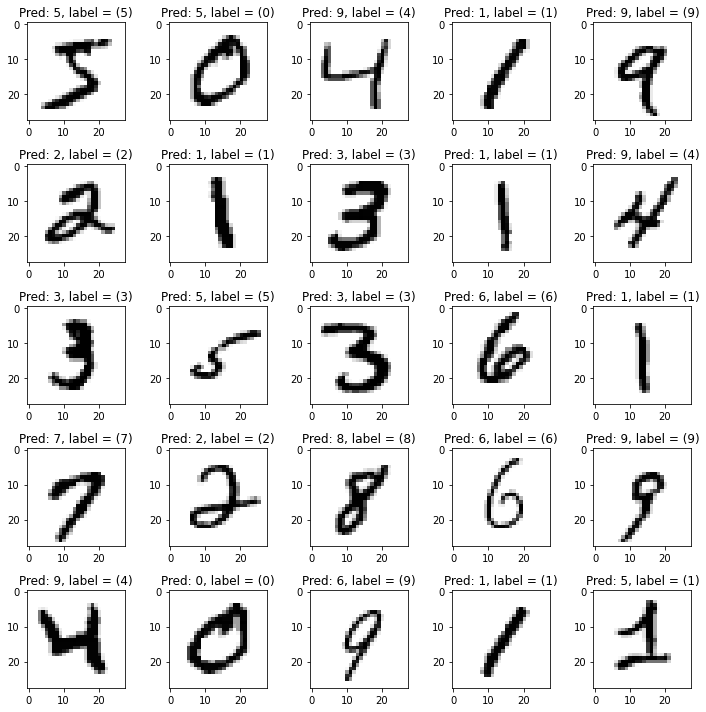

In [55]:

n_rows = 5
n_cols = 5
fig = plt.figure(figsize=(10, 10)) # width and height in inches? lol

for i, image in enumerate(training_data_mnist):
    if i >= n_rows*n_cols:
        break

    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # Getting image and prepare it for visualisation
    image_tensor, label = image 
    # image_tensor = torch.flatten(image_tensor)

    prediction = my_mlp(image_tensor)
    predicted_label = torch.argmax(prediction) # get node with max activation
    ax.title.set_text(f"Pred: {predicted_label}, label = ({label})")
    plt.imshow(torch.squeeze(image_tensor), cmap=plt.cm.binary)

    
plt.tight_layout()

## Exercise 11
Do the same as in the previous exercise, with the same images. But this time, before predicting the label shift all the images 3 pixels to the right. You may use `torch.roll` to perform the shift.


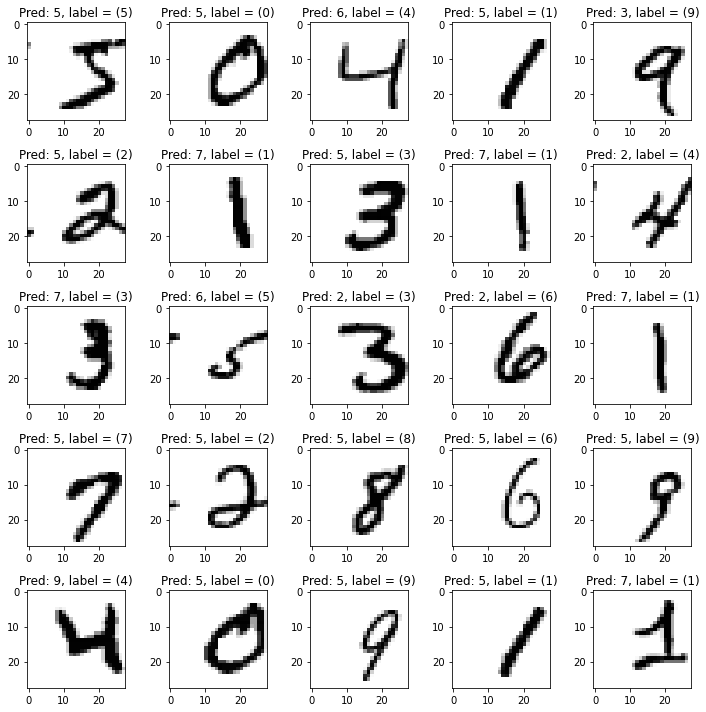

In [56]:

n_shifts = 5
n_rows = 5
n_cols = 5
fig = plt.figure(figsize=(10, 10)) # width and height in inches? lol

for i, image in enumerate(training_data_mnist):
    if i >= n_rows*n_cols:
        break

    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # Getting image and prepare it for visualisation
    image_tensor, label = image 
    
    # We roll the image to see whether classification still performs as well as above
    image_tensor = torch.roll(image_tensor, n_shifts)
    prediction = my_mlp(image_tensor)
    predicted_label = torch.argmax(prediction) # get node with max activation
    ax.title.set_text(f"Pred: {predicted_label}, label = ({label})")
    plt.imshow(torch.squeeze(image_tensor), cmap=plt.cm.binary)


    
plt.tight_layout()

## Exercise 12
Compare the predicted labels, and explain the difference you observe.


We get worse performance, because the model does not take relative but absolute performance into account

We are now going to compute the accuracy on the whole test set. Here we could iterate over the `test_set` one image at a time. But to leverage parallelisation and reduce computational cost we will iterate over the test set in batches using the `test_loader`.

## Exercise 13
What's the accuracy of the model on the full test set?


In [57]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs


total = len(training_data_mnist)
with torch.no_grad():
    for i, image in enumerate(training_data_mnist):
        image_tensor, label = image 

        # image_tensor = torch.roll(image_tensor, n_shifts)

        prediction = my_mlp(image_tensor)
        predicted_label = torch.argmax(prediction) # get node with max activation

        if predicted_label == label:
            correct += 1




print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 67 %


## Exercise 14
What's the accuracy of the model on the full test set if we apply the image shift of 3 pixels to the right? (Verify by plotting the last batch that the images have been shifted correctly)

In [58]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs

n_shifts = 3

total = len(training_data_mnist)
with torch.no_grad():
    for i, image in enumerate(training_data_mnist):
        image_tensor, label = image 

        image_tensor = torch.roll(image_tensor, n_shifts)

        prediction = my_mlp(image_tensor)
        predicted_label = torch.argmax(prediction) # get node with max activation

        if predicted_label == label:
            correct += 1




print('Accuracy of the network on the 10000 test shifted images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test shifted images: 30 %


We will now explore further the performance on the original (non-shifted) version of the test set.

To start with we will look a the confusion matrix. For this we may use the [`sklearn.metrics.ConfusionMatrixDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions)

## Exercise 15

Plot the confusion matrix over the test set.

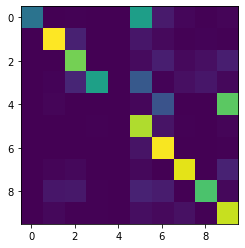

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay


y = []
y_pred = []
with torch.no_grad():
    for i, image in enumerate(training_data_mnist):
        image_tensor, label = image 

        prediction = my_mlp(image_tensor)
        predicted_label = torch.argmax(prediction) # get node with max activation
        
        y.append(label)
        y_pred.append(predicted_label)

confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)
plt.imshow(confusion_matrix)
s

plt.show()

## Exercise 16

Do the same on the 3-pixel right-shifted images.

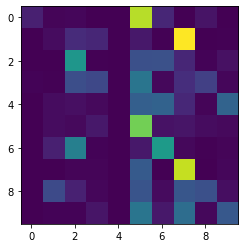

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay


y = []
y_pred = []
with torch.no_grad():
    for i, image in enumerate(training_data_mnist):
        image_tensor, label = image 

        image_tensor = torch.roll(image_tensor, n_shifts)

        prediction = my_mlp(image_tensor)
        predicted_label = torch.argmax(prediction) # get node with max activation
        
        y.append(label)
        y_pred.append(predicted_label)

confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred) # confusion matrix plot method not available, although update to latest scipy
plt.imshow(confusion_matrix)


plt.show()

## Exercise 17

Discuss the differences in the confusion matrix. 

**Your discussion here**

# Miss-predictions

One last aspect that we are going to explore is the actual mistakes that the model does. A way to interpret the output of the model is as a probability distribution over possible classes. 


With respect to this predicted probability distribution we may order the model's mistakes on a scale between two extremes:
- examples for which the model is equally confused among all alternative classes
- examples for which the model is 100% certain about it belonging to an incorrect class

This quality can be measured by the entropy of the distribution among incorrect classes.

The entropy can be measured using the [`torch.distributions.Categorical`](https://pytorch.org/docs/stable/distributions.html#categorical).

**Hint:** The model outputs the logits. To obtain an actual probability distribution we must first apply the `torch.softmax` operation on the logits.

**Hint:** That if we want to check the entropy among **alternative** classes we must first set the probability to 0 for the correct class.

**Hint:** In order to find the k-highest (or k-lowest) values of a tensor we may use [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html)

## [Optional] Exercise 18

Show the 16 test mispredicted images with **highest** prediction entropy among wrong classes.

Show the 16 test mispredicted images with **lowest** prediction entropy among wrong classes.

In [69]:
from torch.distributions import Categorical

all_labels = []
all_logits = []
all_images = [] 



# Forward path: we get all the classifications 
with torch.no_grad():
    for i, image in enumerate(training_data_mnist):
        image_tensor, label = image 

        image_tensor = torch.roll(image_tensor, n_shifts)

        prediction = my_mlp(image_tensor)
        logits = Categorical(prediction)
        
        all_labels.append(label)
        all_logits.append(logits)
        all_images.append(image_tensor)

# We now find the highest / lowest prediction entropy in those classes
min_entropy = all_logits.argsort()[:16] # TODO regularise to [0, 1]
max_entropy = all_logits.argsort()[-16:]




ValueError: Expected parameter probs (Tensor of shape (1, 10)) of distribution Categorical(probs: torch.Size([1, 10])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[  8.1868,  15.0369,  -4.0546, -28.2062,  42.1346, -37.3273,   5.5783,
          -5.2056,  -0.5496,   5.4068]])